In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.models.time_series_model import TimeSeriesModel
from src.special_preprocessing.first_special_pipeline.pipeline import preprocessing_pipeline
from src.utils import train_test_split_by_months
from sklearn.model_selection import TimeSeriesSplit
from configs.models_collector import ModelsCollector
from configs.models_configs import ModelsConfigs
from src.metrics.forecast_accuracy import forecast_accuracy
from prophet import Prophet
from random import seed
import numpy as np

/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv("../datasets/first_dataset/demo_data.csv", parse_dates=["date"])
data = data.sort_values(by=["date"])
X_marked = train_test_split_by_months(data, date_column="date", test_months=1)

In [4]:
selector = ModelsCollector(ModelsConfigs)
trend_models = selector.get_configs(["KNeighborsRegressor", "SVR"])
seasonal_models = selector.get_configs(["XGBRegressor", "GradientBoostingRegressor", "CatBoost"])

In [5]:
tscv = TimeSeriesSplit(n_splits=4)
tsm = TimeSeriesModel(trend_models, seasonal_models, cv=tscv, scoring="neg_mean_absolute_error")

In [6]:
preprocessing_pipeline.steps[-1][1].production_mode = False

In [7]:
X = preprocessing_pipeline.fit_transform(X_marked)

In [8]:
X_train, y_train = X[X["mark"] == "train"].drop(columns =["ship", "mark"]), X[X["mark"] == "train"]["ship"]
X_test, y_test = X[X["mark"] == "test"].drop(columns=["ship", "trend", "seasonal", "mark"]), X[X["mark"] == "test"]["ship"]

In [9]:
tsm.fit(X_train)
tsm_prediction = tsm.predict(X_test)
tsm_prediction["Actual"] = y_test.values

/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/enge

In [10]:
X_train["y"] = y_train.values
X_train = X_train.drop(columns = ["seasonal", "trend"])
X_train = X_train.rename(columns = {"date": "ds"})
X_test = X_test.rename(columns = {"date": "ds"})

In [11]:
probnet_prediction = pd.DataFrame()
excluded_columns = ['ds', 'y', "key"]
for key in X_train["key"].unique():
    m = Prophet(seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=True,)
    for col in X_train.columns:
        if col not in excluded_columns:
            m.add_regressor(col)

    m.fit(X_train[X_train["key"] == key])
    pred = m.predict(X_test[X_test["key"] == key])
    pred["key"] = key
    probnet_prediction = pd.concat([probnet_prediction, pred])
probnet_prediction = probnet_prediction.rename(columns = {"ds": "date", "yhat": "Forecast"})
probnet_prediction["Actual"] = y_test.values

23:23:20 - cmdstanpy - INFO - Chain [1] start processing
23:23:20 - cmdstanpy - INFO - Chain [1] done processing
23:23:20 - cmdstanpy - INFO - Chain [1] start processing
23:23:20 - cmdstanpy - INFO - Chain [1] done processing
23:23:21 - cmdstanpy - INFO - Chain [1] start processing
23:23:21 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:23 - cmdstanpy - INFO - Chain [1] start processing
23:23:23 - cmdstanpy - INFO - Chain [1] done processing
23:23:23 - cmdstanpy - INFO - Chain [1] start processing
23:23:24 - cmdstanpy - INFO - Chain [1] done processing
23:23:24 - cmdstanpy - INFO - Chain [1] start processing
23:23:24 - cmdstanpy - INFO - Chain [1]

In [12]:
result = forecast_accuracy(tsm_prediction, time_period="ME")[["date", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="ME")["Acc"].values

In [13]:
result

,date,TSM Acc,ProbNet Acc
0,2023-07-31,0.000000,0.000000
1,2023-08-31,0.915616,0.771582


In [14]:
result = forecast_accuracy(tsm_prediction, time_period="ME", ae_gr_cols=["key"])[["date", "key", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="ME", ae_gr_cols=["key"])["Acc"].values
result["key"] = pd.factorize(result["key"])[0] + 1

In [15]:
result

,date,key,TSM Acc,ProbNet Acc
0,2023-07-31,1,0.000000,0.000000
1,2023-07-31,2,0.000000,0.000000
2,2023-07-31,3,0.000000,0.000000
3,2023-07-31,4,0.000000,0.000000
4,2023-07-31,5,0.000000,0.000000
5,2023-07-31,6,0.000000,0.000000
6,2023-07-31,7,0.000000,0.000000
7,2023-07-31,8,0.000000,0.000000
8,2023-07-31,9,0.000000,0.000000
9,2023-07-31,10,0.000000,0.000000


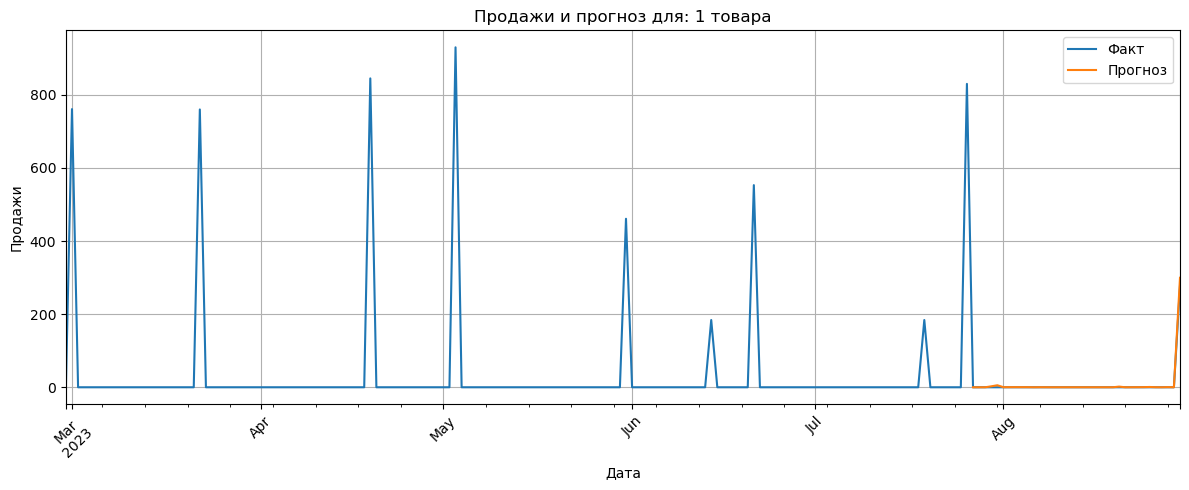

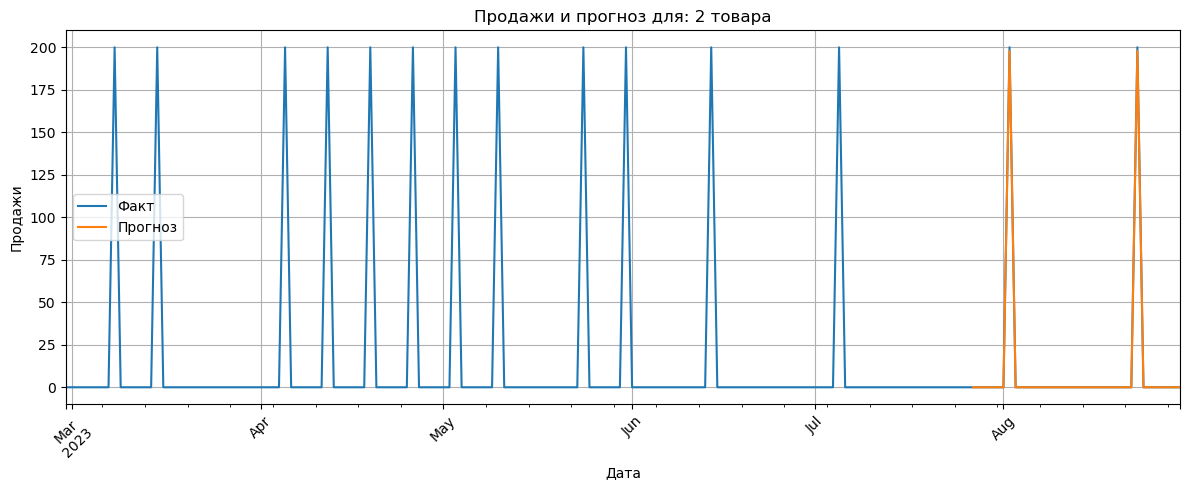

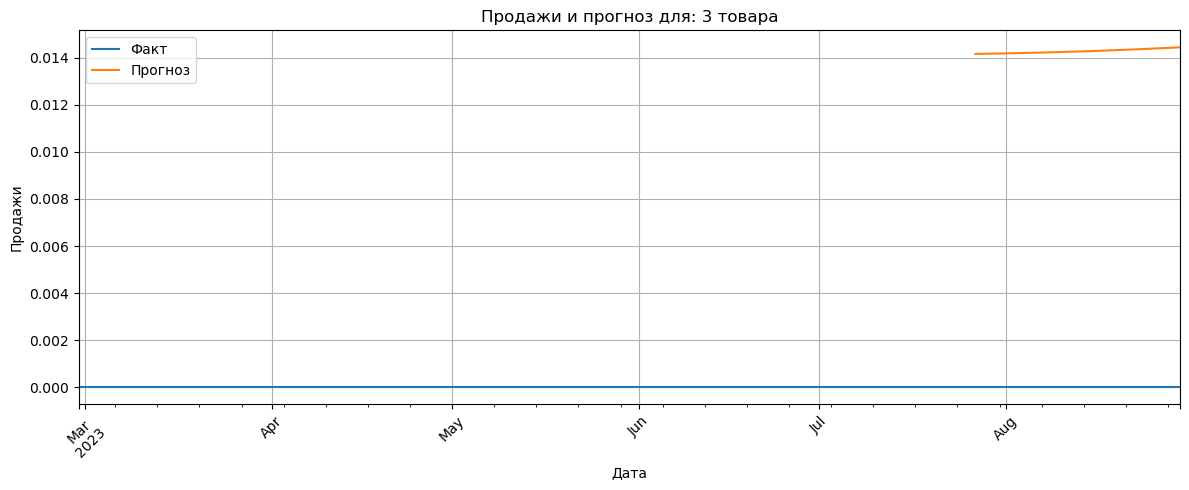

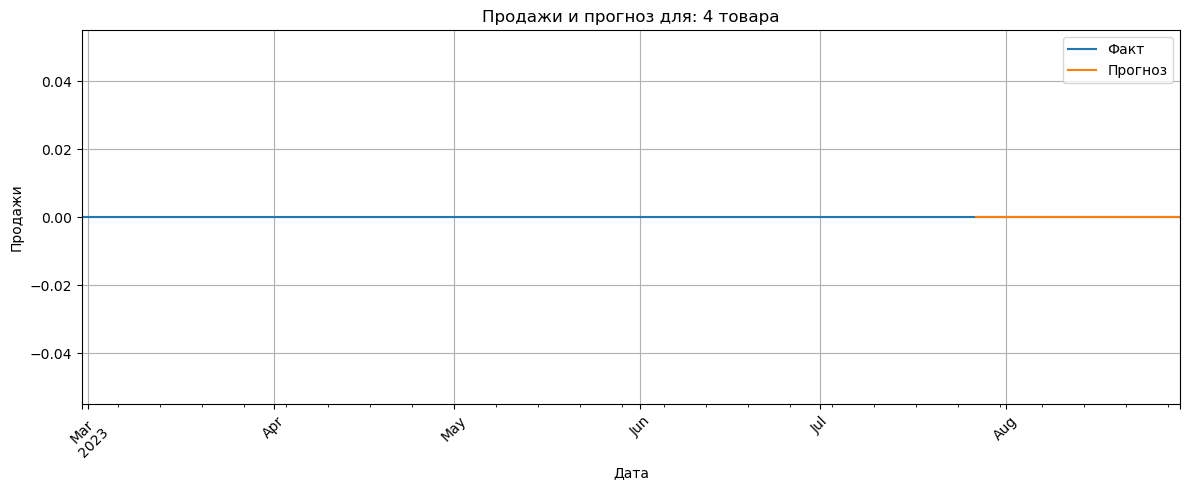

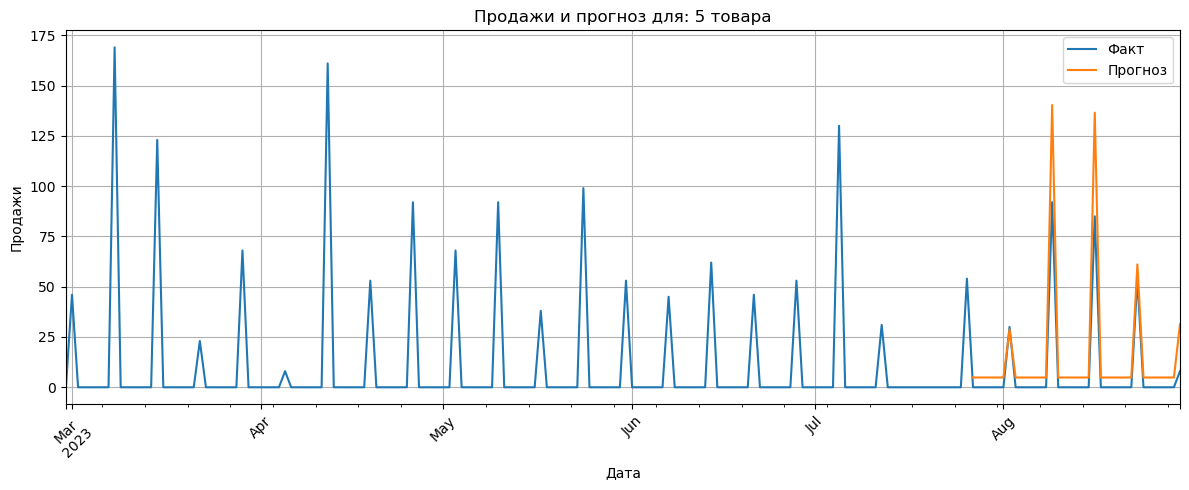

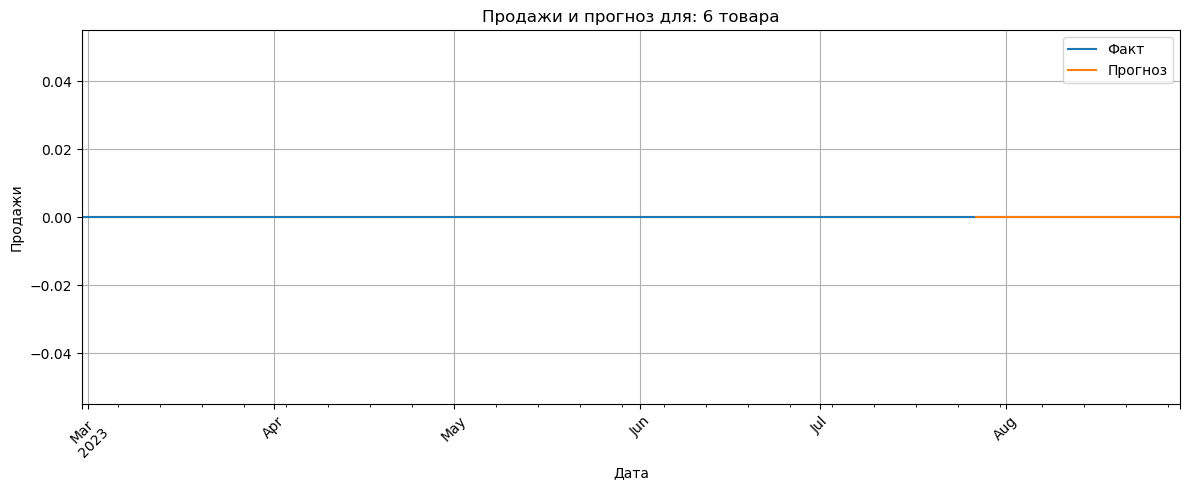

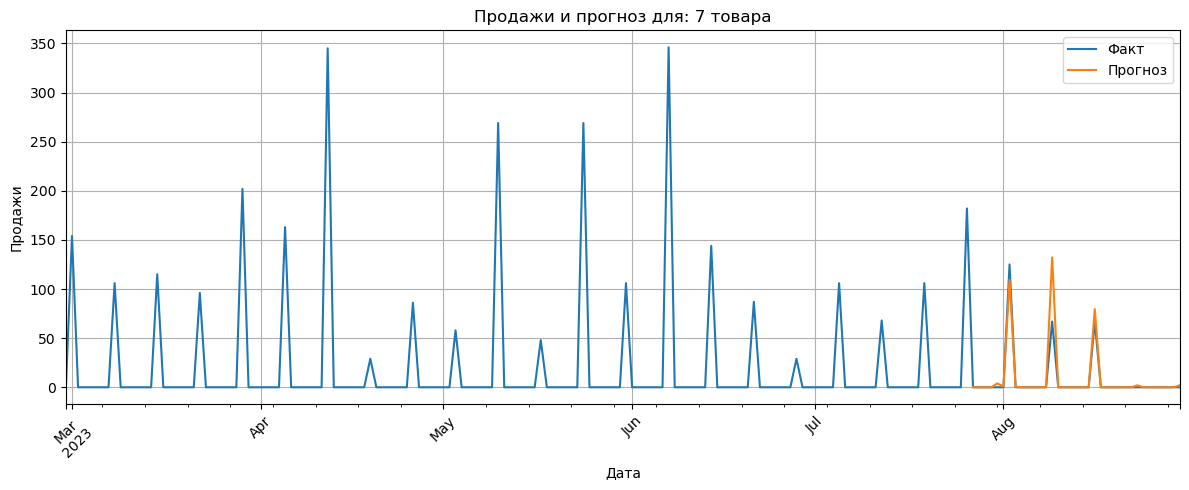

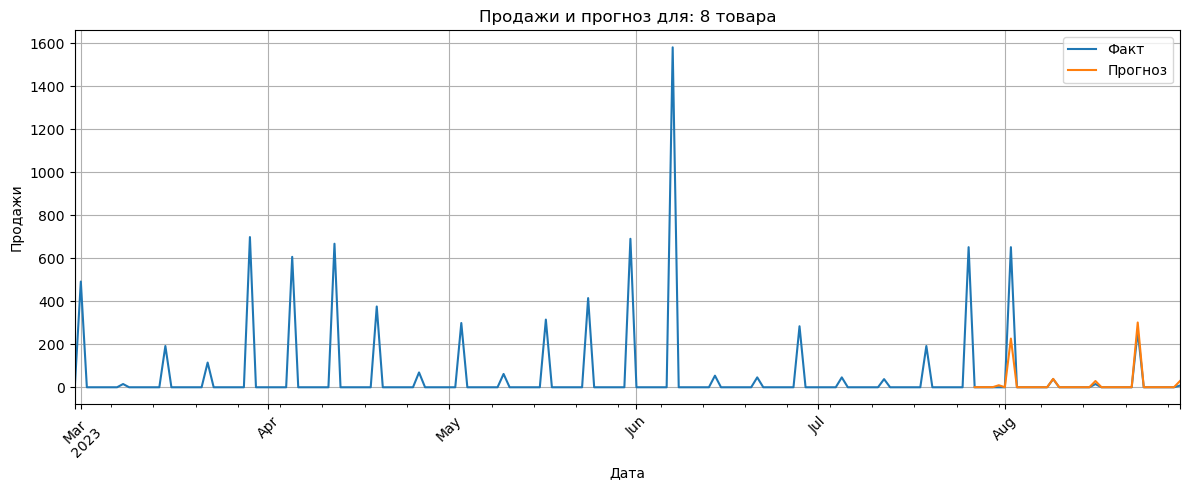

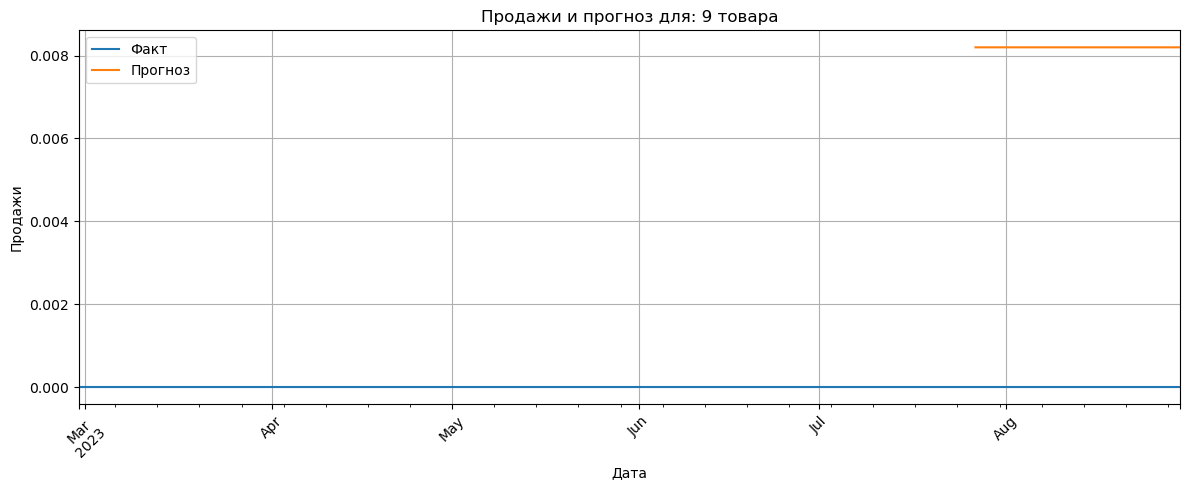

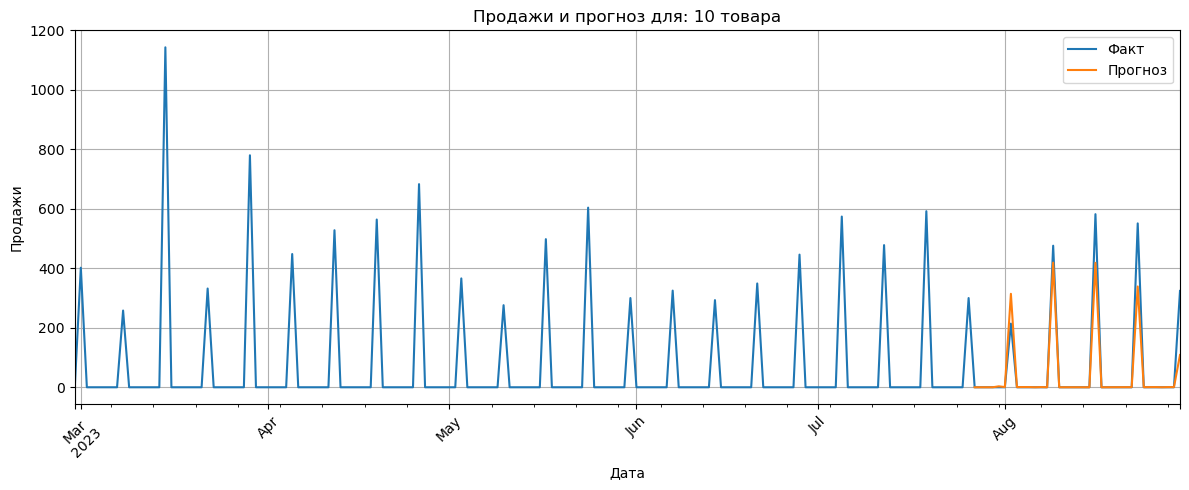

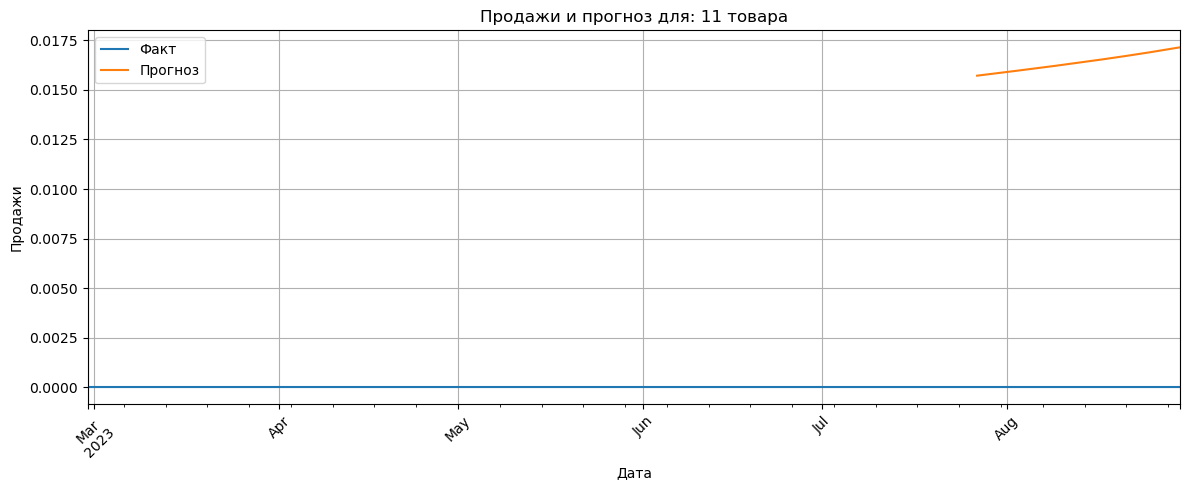

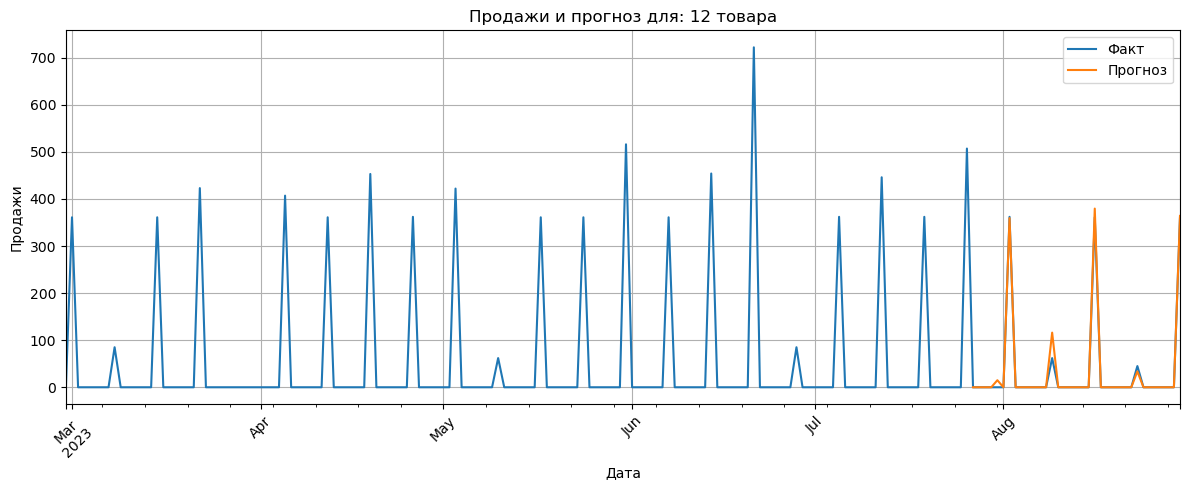

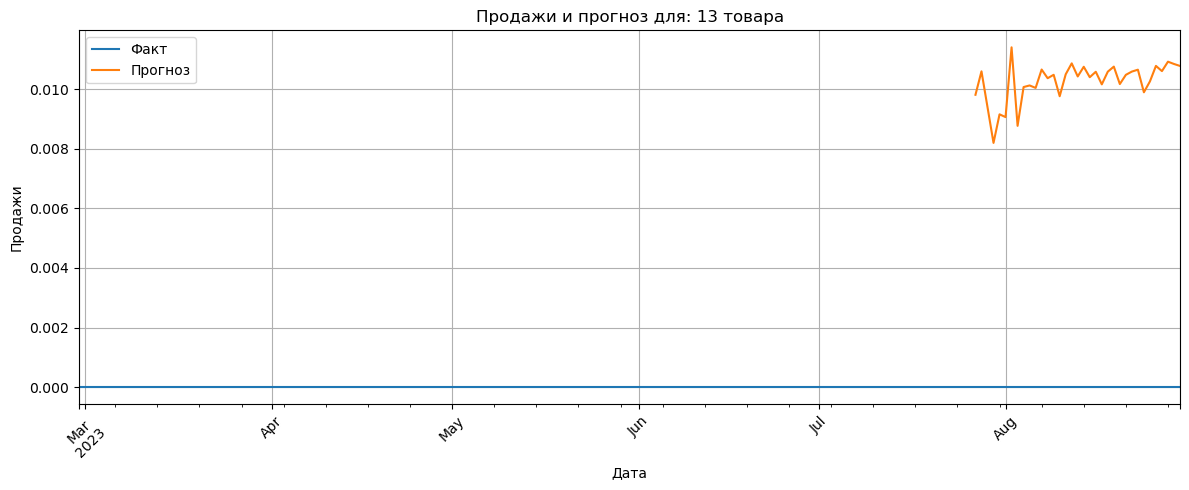

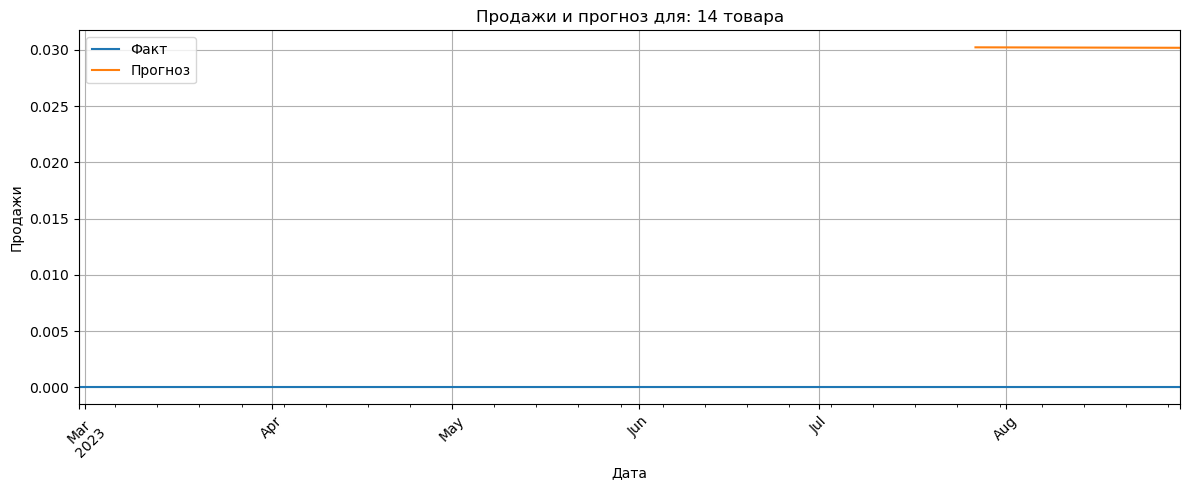

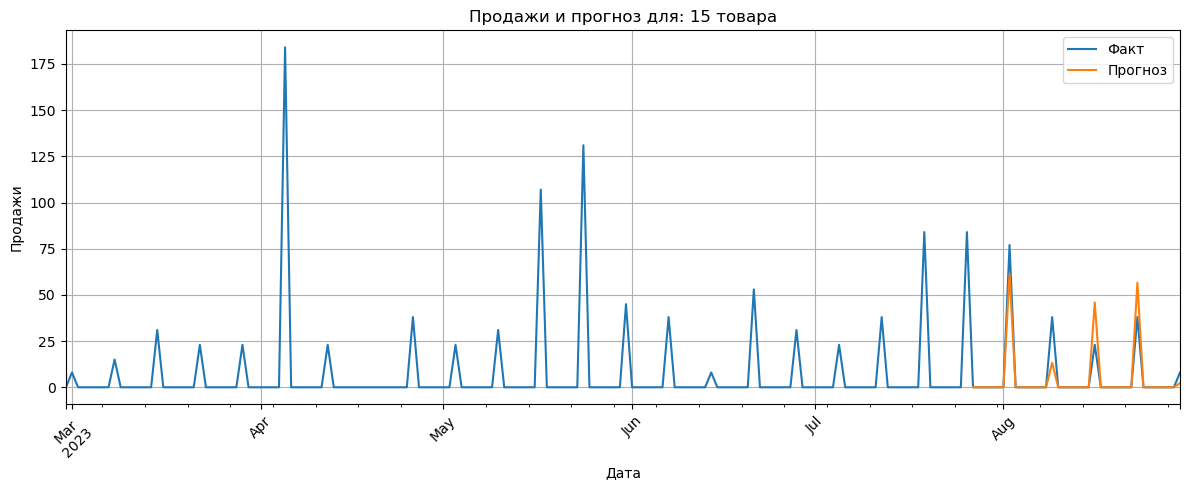

In [16]:
keys = X["key"].unique()

for idx, key in enumerate(keys, 1):
    pred_key_df = tsm_prediction[tsm_prediction["key"] == key]
    last_pred_date = pred_key_df["date"].max()
    start_date = last_pred_date - pd.DateOffset(months=6)

    real_key_df = X[(X["key"] == key) & (X["date"] >= start_date) & (X["date"] <= last_pred_date)]

    combined_df = pd.merge(
        real_key_df[["date", "key", "ship"]], pred_key_df[["date", "key", "Forecast"]], on=["date", "key"], how="outer"
    )

    combined_df = combined_df.sort_values("date").set_index("date")

    combined_df[["ship", "Forecast"]].plot.line(figsize=(12, 5), title=f"Продажи и прогноз для: {idx} товара")
    plt.xlabel("Дата")
    plt.ylabel("Продажи")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(["Факт", "Прогноз"])
    plt.tight_layout()
    plt.show()